In [92]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## !! CHANGE ME !! ##
os.chdir('C:\\ali\\packages\\s2p-lbm')

In [3]:
from suite2p.io import lbm as lbmio
from suite2p.suite3d.job import Job
from suite2p.suite3d import extension as ext

from suite2p.suite3d import iter_step
from utils import tiff_utils as tfu
from dask import array as darr

## Load previously registered files

In [4]:
## !! Change Me !! ##
analysis_dir = 'Y:\\analysis\\example'

In [5]:
job = Job(analysis_dir, 'test_experiment_001', create=False)

Job directory Y:\analysis\example\s3d-test_experiment_001 already exists
Loading job directory for test_experiment_001 in Y:\analysis\example
   Loading dirs 
      Found dir registered_data
      Found dir summary
      Found dir iters
   Found and loaded params from Y:\analysis\example\s3d-test_experiment_001\params.npy
      Updated params file: Y:\analysis\example\s3d-test_experiment_001\params.npy


In [6]:
summary = job.load_summary()

## Calculate correlation map

In [436]:
job.params['t_batch_size'] = 1000 # how many frames to process in each batch
                                 # the memory requirement is about 8x the size of the array
                                 # so maybe do 1/10 of your RAM to be safe
        
job.params['temporal_hpf'] = 100 # width of the temporal rolling average filter 

job.params['npil_hpf_xy'] = 8    # width in pixels of the neuropil filter, this works for 3.5 um/pix resolution
job.params['npil_hpf_z'] = 2     # same, in z

job.params['unif_filter_xy'] = 3 # roughly, minimum width in pixels of a cell. this works for 3.5 um/pix resolution
job.params['unif_filter_z'] = 3  # same, in z

# time points where value of the normalized movie is below this threshold will not be used for the corr map
# increasing will increase the difference between the bright and dim spots of the corrmap, effectively making 
# the background darker. But if you increase too much, you will start losing ROIs and everything will become black.
# It always works fine if you leave it at 0, increasing it might improve things or make them worse
job.params['intensity_thresh'] = 0

job.params['n_proc_corr'] = 12  # number of processors to use for correlation map calculation
job.params['mproc_batchsize'] = 100 # for the filtering step, size (in frames) of the batch each process will get
job.params['fix_vmap_edges'] = True # fixes the magnitude of the edge planes (filtering makes them artificially different)

In [437]:
mov3d = job.get_registered_movie('registered_fused_data', 'fused')[:,:1000]
nz,nt,ny,nx = mov3d.shape

In [438]:
# to test out parameters before running on the whole thing, you can do this (which won't save the vmap):
# vmap_test = job.calculate_corr_map(mov3d[0:5, :1000, 600:800, 200:400])

In [439]:
# once you have optimized your parameters, you can run on the full FOV and save
vmap = job.calculate_corr_map(mov3d)

   Created files and dirs for 1 batches
0
      Running batch 1
      Loaded and swapped from dask, idx 0 to 1000
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
         Sub and conv
         Vmap
      Saving to Y:\analysis\example\s3d-test_experiment_001\iters\batch0000


[autoreload of suite2p.suite3d.job failed: Traceback (most recent call last):
  File "C:\Users\ali\anaconda3\envs\s2p-lbm\lib\site-packages\IPython\extensions\autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\ali\anaconda3\envs\s2p-lbm\lib\site-packages\IPython\extensions\autoreload.py", line 459, in superreload
    module = reload(module)
  File "C:\Users\ali\anaconda3\envs\s2p-lbm\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 839, in exec_module
  File "<frozen importlib._bootstrap_external>", line 976, in get_code
  File "<frozen importlib._bootstrap_external>", line 906, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "c:\ali\packages\s2p-lbm\suite2p\suite2p\suite3d\job.py", line 181
    self.make_new_dir('patch-%04d', parent_dir_nam

(<Figure size 1200x900 with 1 Axes>,
 <AxesSubplot: >,
 <matplotlib.image.AxesImage at 0x12c8bf9ccd0>)

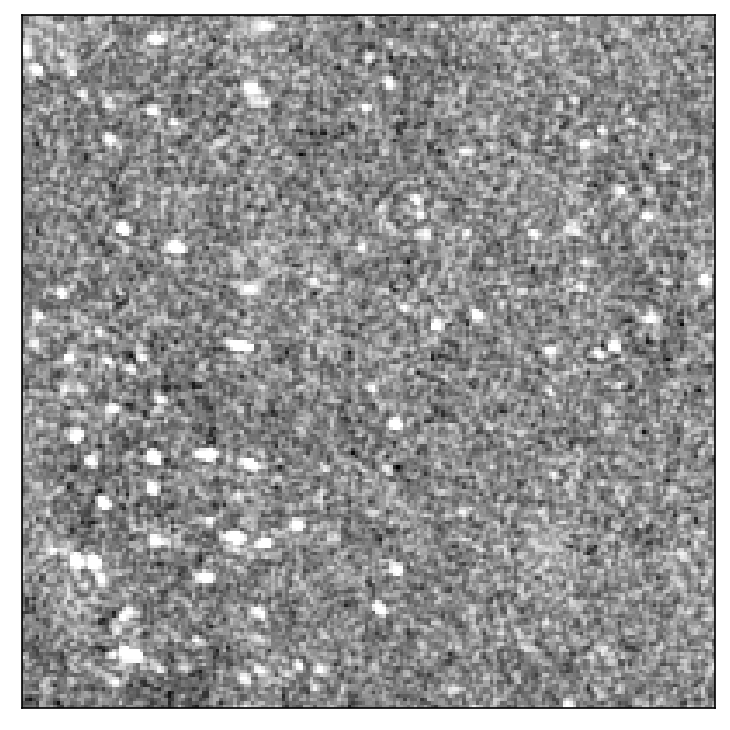

In [440]:
tfu.show_tif(vmap[2,600:800, 200:400], vminmax=(3,5))

## Cell detection

In [443]:
# this is the minimum value of a peak in the correlation map for it to count as an ROI. Reduce to find more 
# ROIs, increase to find less ROIs (but higher percentage of real cells, probably)
job.params['peak_thresh'] = 4

# these two params select the "active frames" that are used to decide whether candidate pixels are 
# active at the same time as the seed ROI
# if they are too high, the cell extension process will be noisier and non-cell pixels are likelier 
# to be included in the main ROI, so if you see a lot of cells with non-smooth edges and pixels sticking out,
# try to decrease these two values
job.params['activity_thresh'] = 1.5
job.params['percentile'] = 95


job.params['max_iter'] = 10000 # maximum number of ROIs detected in given patch

job.params['detection_timebin'] = 2  # downsample (time-bin) movie by this factor for detection
                                     # to save RAM and accelerate. Should be roughly ~1 frame / action potential,
                                     # I downsample from 2.8 Hz to 1.4 Hz for my G6s recordings
                                     # also speeds things up quite a bit! 
        
# better to not mess with these
job.params['extend_thresh'] = 0.2    # When extending an ROI, the threshold of shared activty above which a candidate pixel will be added to ROI
job.params['roi_ext_iterations'] = 2 # how many times to recompute timecourse and re-extend  each ROI. lower: smaller ROIs, higher: bigger ROIs.

In [ ]:
stats = job.extract_cells_from_patch(patch_idx = 0, zs = (0,5), ys = (600,800), xs = (200,400))

   Saving cell stats and info to Y:\analysis\example\s3d-test_experiment_001\detection\patch-0000
   Loading from Y:\analysis\example\s3d-test_experiment_001\iters\batch0000
   Starting extraction with peak_thresh: 4.000 and Th2: 1.500
      Cell 0 at with peak 7.136, activity_thresh 1.500, max 3.137
         43/500 active frames
         95/500 active frames
      Added cell 1 at 04, 128, 038 with peak: 7.136 and 32 pixels
      Cell 1 at with peak 6.225, activity_thresh 1.500, max 3.288
         28/500 active frames
         58/500 active frames
      Added cell 2 at 00, 095, 060 with peak: 6.225 and 46 pixels
      Cell 2 at with peak 6.022, activity_thresh 1.500, max 3.959
         33/500 active frames
         43/500 active frames
      Added cell 3 at 00, 100, 025 with peak: 6.022 and 21 pixels
      Cell 3 at with peak 5.954, activity_thresh 1.500, max 6.628
         28/500 active frames
         38/500 active frames
      Added cell 4 at 02, 184, 030 with peak: 5.954 and 62 pix

      Cell 48 at with peak 4.930, activity_thresh 1.500, max 4.361
         29/500 active frames
         38/500 active frames
      Added cell 49 at 00, 096, 023 with peak: 4.930 and 15 pixels
      Cell 49 at with peak 4.928, activity_thresh 1.032, max 2.490
         25/500 active frames
         30/500 active frames
      Added cell 50 at 03, 129, 039 with peak: 4.928 and 15 pixels
      Cell 50 at with peak 4.924, activity_thresh 1.300, max 3.133
         25/500 active frames
         34/500 active frames
      Added cell 51 at 02, 007, 038 with peak: 4.924 and 30 pixels
      Cell 51 at with peak 4.912, activity_thresh 1.441, max 3.615
         25/500 active frames
         31/500 active frames
      Added cell 52 at 02, 095, 170 with peak: 4.912 and 31 pixels
      Cell 52 at with peak 4.910, activity_thresh 1.477, max 3.134
         25/500 active frames
         28/500 active frames
      Added cell 53 at 01, 026, 099 with peak: 4.910 and 20 pixels
      Cell 53 at with peak 4.9

      Added cell 92 at 02, 036, 025 with peak: 4.645 and 22 pixels
      Cell 92 at with peak 4.644, activity_thresh 1.283, max 3.602
         25/500 active frames
         28/500 active frames
      Added cell 93 at 04, 038, 057 with peak: 4.644 and 23 pixels
      Cell 93 at with peak 4.641, activity_thresh 1.143, max 2.837
         25/500 active frames
         30/500 active frames
      Added cell 94 at 01, 199, 087 with peak: 4.641 and 14 pixels
      Cell 94 at with peak 4.623, activity_thresh 1.071, max 2.393
         25/500 active frames
         32/500 active frames
      Added cell 95 at 02, 094, 062 with peak: 4.623 and 19 pixels
      Cell 95 at with peak 4.621, activity_thresh 1.124, max 3.067
         25/500 active frames
         29/500 active frames
      Added cell 96 at 02, 096, 152 with peak: 4.621 and 16 pixels
      Cell 96 at with peak 4.618, activity_thresh 1.076, max 2.133
         25/500 active frames
         32/500 active frames
      Added cell 97 at 02, 086

         31/500 active frames
      Added cell 137 at 01, 185, 034 with peak: 4.475 and 21 pixels
      Cell 137 at with peak 4.470, activity_thresh 1.177, max 2.879
         25/500 active frames
         34/500 active frames
      Added cell 138 at 03, 198, 157 with peak: 4.470 and 23 pixels
      Cell 138 at with peak 4.470, activity_thresh 1.190, max 3.509
         25/500 active frames
         35/500 active frames
      Added cell 139 at 03, 007, 037 with peak: 4.470 and 11 pixels
      Cell 139 at with peak 4.470, activity_thresh 1.421, max 3.147
         25/500 active frames
         30/500 active frames
      Added cell 140 at 03, 026, 025 with peak: 4.470 and 17 pixels
      Cell 140 at with peak 4.465, activity_thresh 1.104, max 2.157
         25/500 active frames
         30/500 active frames
      Added cell 141 at 04, 026, 025 with peak: 4.465 and 17 pixels
      Cell 141 at with peak 4.463, activity_thresh 1.120, max 2.937
         25/500 active frames
         26/500 acti

         28/500 active frames
      Added cell 181 at 01, 155, 011 with peak: 4.401 and 12 pixels
      Cell 181 at with peak 4.398, activity_thresh 1.053, max 2.133
         25/500 active frames
         28/500 active frames
      Added cell 182 at 04, 128, 036 with peak: 4.398 and 10 pixels
      Cell 182 at with peak 4.398, activity_thresh 1.106, max 2.066
         25/500 active frames
         28/500 active frames
      Added cell 183 at 04, 160, 107 with peak: 4.398 and 12 pixels
      Cell 183 at with peak 4.392, activity_thresh 1.290, max 2.813
         25/500 active frames
         27/500 active frames
      Added cell 184 at 03, 037, 057 with peak: 4.392 and 18 pixels
      Cell 184 at with peak 4.389, activity_thresh 1.090, max 2.966
         25/500 active frames
         35/500 active frames
      Added cell 185 at 01, 054, 033 with peak: 4.389 and 25 pixels
      Cell 185 at with peak 4.388, activity_thresh 1.060, max 1.871
         25/500 active frames
         27/500 acti

         31/500 active frames
      Added cell 224 at 02, 031, 044 with peak: 4.334 and 26 pixels
      Cell 224 at with peak 4.334, activity_thresh 1.028, max 2.670
         25/500 active frames
         26/500 active frames
      Added cell 225 at 03, 182, 029 with peak: 4.334 and 13 pixels
      Cell 225 at with peak 4.334, activity_thresh 1.081, max 2.435
         25/500 active frames
         30/500 active frames
      Added cell 226 at 04, 191, 064 with peak: 4.334 and 9 pixels
      Cell 226 at with peak 4.333, activity_thresh 0.972, max 2.196
         25/500 active frames
         27/500 active frames
      Added cell 227 at 00, 039, 129 with peak: 4.333 and 7 pixels
      Cell 227 at with peak 4.333, activity_thresh 0.983, max 1.862
         25/500 active frames
         38/500 active frames
      Added cell 228 at 02, 180, 050 with peak: 4.333 and 11 pixels
      Cell 228 at with peak 4.331, activity_thresh 1.059, max 2.074
         25/500 active frames
         26/500 active

         25/500 active frames
         30/500 active frames
      Added cell 274 at 02, 095, 066 with peak: 4.286 and 12 pixels
      Cell 274 at with peak 4.285, activity_thresh 1.186, max 2.497
         25/500 active frames
         30/500 active frames
      Added cell 275 at 02, 075, 196 with peak: 4.285 and 12 pixels
      Cell 275 at with peak 4.284, activity_thresh 1.335, max 3.576
         25/500 active frames
         30/500 active frames
      Added cell 276 at 03, 095, 003 with peak: 4.284 and 23 pixels
      Cell 276 at with peak 4.282, activity_thresh 0.971, max 2.359
         25/500 active frames
         32/500 active frames
      Added cell 277 at 03, 053, 183 with peak: 4.282 and 14 pixels
      Cell 277 at with peak 4.282, activity_thresh 1.104, max 2.288
         25/500 active frames
         28/500 active frames
      Added cell 278 at 00, 031, 160 with peak: 4.282 and 13 pixels
      Cell 278 at with peak 4.281, activity_thresh 0.927, max 1.981
         25/500 acti

      Added cell 322 at 03, 024, 159 with peak: 4.227 and 9 pixels
      Cell 322 at with peak 4.226, activity_thresh 1.078, max 2.203
         25/500 active frames
         30/500 active frames
      Added cell 323 at 02, 150, 037 with peak: 4.226 and 12 pixels
      Cell 323 at with peak 4.226, activity_thresh 1.116, max 2.322
         25/500 active frames
         28/500 active frames
      Added cell 324 at 04, 067, 046 with peak: 4.226 and 14 pixels
      Cell 324 at with peak 4.224, activity_thresh 1.044, max 1.942
         25/500 active frames
         28/500 active frames
      Added cell 325 at 03, 113, 131 with peak: 4.224 and 11 pixels
      Cell 325 at with peak 4.223, activity_thresh 1.165, max 2.052
         25/500 active frames
         29/500 active frames
      Added cell 326 at 04, 087, 004 with peak: 4.223 and 12 pixels
      Cell 326 at with peak 4.221, activity_thresh 0.914, max 2.011
         25/500 active frames
         27/500 active frames
      Added cell 327 

      Added cell 369 at 01, 140, 085 with peak: 4.196 and 15 pixels
      Cell 369 at with peak 4.196, activity_thresh 1.073, max 1.838
         25/500 active frames
         29/500 active frames
      Added cell 370 at 02, 025, 068 with peak: 4.196 and 12 pixels
      Cell 370 at with peak 4.196, activity_thresh 1.389, max 2.731
         25/500 active frames
         28/500 active frames
      Added cell 371 at 00, 145, 018 with peak: 4.196 and 12 pixels
      Cell 371 at with peak 4.196, activity_thresh 1.198, max 2.293
         25/500 active frames
         29/500 active frames
      Added cell 372 at 03, 055, 192 with peak: 4.196 and 14 pixels
      Cell 372 at with peak 4.195, activity_thresh 1.172, max 2.449
         25/500 active frames
         24/500 active frames
      Added cell 373 at 04, 070, 062 with peak: 4.195 and 9 pixels
      Cell 373 at with peak 4.195, activity_thresh 1.256, max 3.785
         25/500 active frames
         25/500 active frames
      Added cell 374 

      Added cell 417 at 01, 011, 179 with peak: 4.171 and 13 pixels
      Cell 417 at with peak 4.169, activity_thresh 1.229, max 3.468
         25/500 active frames
         25/500 active frames
      Added cell 418 at 00, 055, 141 with peak: 4.169 and 13 pixels
      Cell 418 at with peak 4.169, activity_thresh 0.993, max 2.516
         25/500 active frames
         35/500 active frames
      Added cell 419 at 03, 138, 047 with peak: 4.169 and 15 pixels
      Cell 419 at with peak 4.169, activity_thresh 1.253, max 2.889
         25/500 active frames
         27/500 active frames
      Added cell 420 at 04, 059, 060 with peak: 4.169 and 8 pixels
      Cell 420 at with peak 4.168, activity_thresh 1.020, max 2.745
         25/500 active frames
         30/500 active frames
      Added cell 421 at 01, 066, 042 with peak: 4.168 and 15 pixels
      Cell 421 at with peak 4.168, activity_thresh 0.862, max 2.195
         25/500 active frames
         33/500 active frames
      Added cell 422 

         25/500 active frames
         28/500 active frames
      Added cell 465 at 00, 199, 082 with peak: 4.153 and 9 pixels
      Cell 465 at with peak 4.153, activity_thresh 1.194, max 2.392
         25/500 active frames
         24/500 active frames
      Added cell 466 at 02, 154, 061 with peak: 4.153 and 10 pixels
      Cell 466 at with peak 4.153, activity_thresh 1.016, max 2.639
         25/500 active frames
         32/500 active frames
      Added cell 467 at 03, 108, 014 with peak: 4.153 and 11 pixels
      Cell 467 at with peak 4.153, activity_thresh 1.057, max 1.969
         25/500 active frames
         27/500 active frames
      Added cell 468 at 01, 089, 079 with peak: 4.153 and 15 pixels
      Cell 468 at with peak 4.153, activity_thresh 1.141, max 2.049
         25/500 active frames
         24/500 active frames
      Added cell 469 at 03, 096, 064 with peak: 4.153 and 11 pixels
      Cell 469 at with peak 4.152, activity_thresh 1.037, max 2.387
         25/500 activ

         25/500 active frames
         30/500 active frames
      Added cell 514 at 02, 158, 151 with peak: 4.138 and 9 pixels
      Cell 514 at with peak 4.138, activity_thresh 1.198, max 3.526
         25/500 active frames
         24/500 active frames
      Added cell 515 at 02, 083, 138 with peak: 4.138 and 12 pixels
      Cell 515 at with peak 4.138, activity_thresh 1.014, max 3.190
         25/500 active frames
         24/500 active frames
      Added cell 516 at 02, 138, 086 with peak: 4.138 and 15 pixels
      Cell 516 at with peak 4.138, activity_thresh 1.146, max 2.241
         25/500 active frames
         25/500 active frames
      Added cell 517 at 01, 010, 001 with peak: 4.138 and 11 pixels
      Cell 517 at with peak 4.138, activity_thresh 1.057, max 2.111
         25/500 active frames
         30/500 active frames
      Added cell 518 at 03, 153, 187 with peak: 4.138 and 26 pixels
      Cell 518 at with peak 4.136, activity_thresh 1.125, max 1.982
         25/500 activ

         27/500 active frames
      Added cell 561 at 03, 004, 195 with peak: 4.124 and 8 pixels
      Cell 561 at with peak 4.123, activity_thresh 1.176, max 3.483
         25/500 active frames
         26/500 active frames
      Added cell 562 at 04, 120, 000 with peak: 4.123 and 7 pixels
      Cell 562 at with peak 4.123, activity_thresh 1.156, max 3.419
         25/500 active frames
         27/500 active frames
      Added cell 563 at 03, 070, 062 with peak: 4.123 and 17 pixels
      Cell 563 at with peak 4.123, activity_thresh 1.075, max 2.836
         25/500 active frames
         29/500 active frames
      Added cell 564 at 03, 115, 062 with peak: 4.123 and 11 pixels
      Cell 564 at with peak 4.123, activity_thresh 0.999, max 2.417
         25/500 active frames
         30/500 active frames
      Added cell 565 at 03, 150, 064 with peak: 4.123 and 11 pixels
      Cell 565 at with peak 4.123, activity_thresh 1.163, max 2.294
         25/500 active frames
         32/500 active

         26/500 active frames
      Added cell 611 at 04, 067, 064 with peak: 4.114 and 14 pixels
      Cell 611 at with peak 4.113, activity_thresh 1.112, max 2.046
         25/500 active frames
         29/500 active frames
      Added cell 612 at 02, 151, 127 with peak: 4.113 and 7 pixels
      Cell 612 at with peak 4.113, activity_thresh 0.971, max 1.884
         25/500 active frames
         32/500 active frames
      Added cell 613 at 04, 159, 021 with peak: 4.113 and 13 pixels
      Cell 613 at with peak 4.113, activity_thresh 0.975, max 2.089
         25/500 active frames
         34/500 active frames
      Added cell 614 at 00, 152, 110 with peak: 4.113 and 26 pixels
      Cell 614 at with peak 4.113, activity_thresh 1.063, max 2.351
         25/500 active frames
         28/500 active frames
      Added cell 615 at 03, 050, 047 with peak: 4.113 and 24 pixels
      Cell 615 at with peak 4.113, activity_thresh 1.291, max 2.099
         25/500 active frames
         25/500 activ

         38/500 active frames
      Added cell 658 at 00, 031, 043 with peak: 4.106 and 8 pixels
      Cell 658 at with peak 4.105, activity_thresh 0.954, max 1.711
         25/500 active frames
         25/500 active frames
      Added cell 659 at 00, 057, 113 with peak: 4.105 and 11 pixels
      Cell 659 at with peak 4.105, activity_thresh 1.049, max 2.659
         25/500 active frames
         32/500 active frames
      Added cell 660 at 02, 131, 098 with peak: 4.105 and 21 pixels
      Cell 660 at with peak 4.105, activity_thresh 1.160, max 2.181
         25/500 active frames
         24/500 active frames
      Added cell 661 at 04, 080, 062 with peak: 4.105 and 10 pixels
      Cell 661 at with peak 4.105, activity_thresh 1.113, max 4.024
         25/500 active frames
         31/500 active frames
      Added cell 662 at 02, 185, 164 with peak: 4.105 and 20 pixels
      Cell 662 at with peak 4.105, activity_thresh 1.179, max 3.137
         25/500 active frames
         28/500 activ

      Added cell 706 at 04, 178, 019 with peak: 4.098 and 10 pixels
      Cell 706 at with peak 4.098, activity_thresh 1.078, max 3.275
         25/500 active frames
         28/500 active frames
      Added cell 707 at 03, 055, 049 with peak: 4.098 and 13 pixels
      Cell 707 at with peak 4.098, activity_thresh 1.122, max 3.139
         25/500 active frames
         26/500 active frames
      Added cell 708 at 03, 198, 055 with peak: 4.098 and 11 pixels
      Cell 708 at with peak 4.097, activity_thresh 1.123, max 3.043
         25/500 active frames
         29/500 active frames
      Added cell 709 at 02, 165, 013 with peak: 4.097 and 13 pixels
      Cell 709 at with peak 4.097, activity_thresh 1.050, max 2.440
         25/500 active frames
         33/500 active frames
      Added cell 710 at 03, 042, 156 with peak: 4.097 and 7 pixels
      Cell 710 at with peak 4.097, activity_thresh 1.189, max 3.131
         25/500 active frames
         25/500 active frames
      Added cell 711 

         25/500 active frames
         24/500 active frames
      Added cell 752 at 00, 119, 015 with peak: 4.091 and 14 pixels
      Cell 752 at with peak 4.090, activity_thresh 1.078, max 2.471
         25/500 active frames
         22/500 active frames
      Added cell 753 at 03, 162, 122 with peak: 4.090 and 16 pixels
      Cell 753 at with peak 4.090, activity_thresh 1.179, max 2.891
         25/500 active frames
         27/500 active frames
      Added cell 754 at 04, 102, 160 with peak: 4.090 and 10 pixels
      Cell 754 at with peak 4.090, activity_thresh 1.006, max 3.314
         25/500 active frames
         29/500 active frames
      Added cell 755 at 04, 184, 169 with peak: 4.090 and 9 pixels
      Cell 755 at with peak 4.090, activity_thresh 1.061, max 3.082
         25/500 active frames
         27/500 active frames
      Added cell 756 at 00, 145, 041 with peak: 4.090 and 16 pixels
      Cell 756 at with peak 4.090, activity_thresh 0.933, max 1.640
         25/500 activ

         25/500 active frames
         27/500 active frames
      Added cell 802 at 02, 174, 197 with peak: 4.084 and 23 pixels
      Cell 802 at with peak 4.084, activity_thresh 1.004, max 2.919
         25/500 active frames
         27/500 active frames
      Added cell 803 at 04, 023, 198 with peak: 4.084 and 13 pixels
      Cell 803 at with peak 4.083, activity_thresh 1.015, max 2.226
         25/500 active frames
         30/500 active frames
      Added cell 804 at 00, 089, 018 with peak: 4.083 and 11 pixels
      Cell 804 at with peak 4.083, activity_thresh 1.092, max 2.523
         25/500 active frames
         27/500 active frames
      Added cell 805 at 02, 038, 028 with peak: 4.083 and 10 pixels
      Cell 805 at with peak 4.083, activity_thresh 1.040, max 2.797
         25/500 active frames
         26/500 active frames
      Added cell 806 at 04, 003, 053 with peak: 4.083 and 14 pixels
      Cell 806 at with peak 4.083, activity_thresh 1.182, max 3.391
         25/500 acti

         28/500 active frames
      Added cell 851 at 04, 124, 001 with peak: 4.077 and 11 pixels
      Cell 851 at with peak 4.077, activity_thresh 1.007, max 1.753
         25/500 active frames
         27/500 active frames
      Added cell 852 at 00, 085, 093 with peak: 4.077 and 14 pixels
      Cell 852 at with peak 4.077, activity_thresh 0.941, max 2.182
         25/500 active frames
         33/500 active frames
      Added cell 853 at 00, 096, 091 with peak: 4.077 and 16 pixels
      Cell 853 at with peak 4.077, activity_thresh 0.988, max 1.808
         25/500 active frames
         26/500 active frames
      Added cell 854 at 02, 188, 047 with peak: 4.077 and 13 pixels
      Cell 854 at with peak 4.076, activity_thresh 0.975, max 1.701
         25/500 active frames
         28/500 active frames
      Added cell 855 at 00, 078, 158 with peak: 4.076 and 16 pixels
      Cell 855 at with peak 4.076, activity_thresh 1.139, max 2.209
         25/500 active frames
         25/500 acti

         33/500 active frames
      Added cell 898 at 03, 004, 061 with peak: 4.072 and 11 pixels
      Cell 898 at with peak 4.072, activity_thresh 1.145, max 2.287
         25/500 active frames
         34/500 active frames
      Added cell 899 at 03, 152, 151 with peak: 4.072 and 10 pixels
      Cell 899 at with peak 4.072, activity_thresh 0.984, max 2.256
         25/500 active frames
         35/500 active frames
      Added cell 900 at 02, 097, 086 with peak: 4.072 and 11 pixels
      Cell 900 at with peak 4.072, activity_thresh 1.168, max 1.960
         25/500 active frames
         26/500 active frames
      Added cell 901 at 00, 154, 153 with peak: 4.072 and 8 pixels
      Cell 901 at with peak 4.072, activity_thresh 0.979, max 2.207
         25/500 active frames
         33/500 active frames
      Added cell 902 at 00, 157, 090 with peak: 4.072 and 9 pixels
      Cell 902 at with peak 4.072, activity_thresh 1.002, max 2.181
         25/500 active frames
         25/500 active

      Added cell 947 at 04, 153, 153 with peak: 4.067 and 10 pixels
      Cell 947 at with peak 4.067, activity_thresh 1.013, max 2.350
         25/500 active frames
         31/500 active frames
      Added cell 948 at 02, 123, 198 with peak: 4.067 and 12 pixels
      Cell 948 at with peak 4.067, activity_thresh 1.250, max 3.290
         25/500 active frames
         23/500 active frames
      Added cell 949 at 02, 064, 014 with peak: 4.067 and 16 pixels
      Cell 949 at with peak 4.067, activity_thresh 1.100, max 2.423
         25/500 active frames
         31/500 active frames
      Added cell 950 at 02, 157, 169 with peak: 4.067 and 9 pixels
      Cell 950 at with peak 4.067, activity_thresh 0.978, max 2.167
         25/500 active frames
         27/500 active frames
      Added cell 951 at 00, 077, 185 with peak: 4.067 and 7 pixels
      Cell 951 at with peak 4.066, activity_thresh 1.170, max 2.121
         25/500 active frames
         26/500 active frames
      Added cell 952 a

      Added cell 994 at 03, 120, 144 with peak: 4.062 and 21 pixels
      Cell 994 at with peak 4.062, activity_thresh 0.969, max 2.075
         25/500 active frames
         27/500 active frames
      Added cell 995 at 00, 061, 160 with peak: 4.062 and 9 pixels
      Cell 995 at with peak 4.062, activity_thresh 1.061, max 2.751
         25/500 active frames
         25/500 active frames
      Added cell 996 at 00, 175, 131 with peak: 4.062 and 9 pixels
      Cell 996 at with peak 4.062, activity_thresh 1.042, max 2.492
         25/500 active frames
         27/500 active frames
      Added cell 997 at 00, 028, 181 with peak: 4.062 and 11 pixels
      Cell 997 at with peak 4.062, activity_thresh 1.176, max 2.271
         25/500 active frames
         23/500 active frames
      Added cell 998 at 02, 060, 105 with peak: 4.062 and 14 pixels
      Cell 998 at with peak 4.062, activity_thresh 0.966, max 2.187
         25/500 active frames
         28/500 active frames
      Added cell 999 a

      Added cell 1042 at 04, 180, 069 with peak: 4.058 and 10 pixels
      Cell 1042 at with peak 4.058, activity_thresh 1.044, max 3.063
         25/500 active frames
         26/500 active frames
      Added cell 1043 at 01, 157, 153 with peak: 4.058 and 11 pixels
      Cell 1043 at with peak 4.058, activity_thresh 1.129, max 2.939
         25/500 active frames
         24/500 active frames
      Added cell 1044 at 01, 087, 180 with peak: 4.058 and 13 pixels
      Cell 1044 at with peak 4.058, activity_thresh 1.126, max 2.147
         25/500 active frames
         33/500 active frames
      Added cell 1045 at 01, 152, 011 with peak: 4.058 and 10 pixels
      Cell 1045 at with peak 4.058, activity_thresh 1.034, max 1.688
         25/500 active frames
         31/500 active frames
      Added cell 1046 at 01, 135, 037 with peak: 4.058 and 13 pixels
      Cell 1046 at with peak 4.058, activity_thresh 1.011, max 2.376
         25/500 active frames
         26/500 active frames
      Adde

      Cell 1089 at with peak 4.055, activity_thresh 1.001, max 2.957
         25/500 active frames
         33/500 active frames
      Added cell 1090 at 03, 009, 143 with peak: 4.055 and 11 pixels
      Cell 1090 at with peak 4.054, activity_thresh 1.140, max 2.103
         25/500 active frames
         26/500 active frames
      Added cell 1091 at 03, 085, 078 with peak: 4.054 and 9 pixels
      Cell 1091 at with peak 4.054, activity_thresh 1.192, max 3.174
         25/500 active frames
         26/500 active frames
      Added cell 1092 at 02, 062, 107 with peak: 4.054 and 12 pixels
      Cell 1092 at with peak 4.054, activity_thresh 1.137, max 2.540
         25/500 active frames
         30/500 active frames
      Added cell 1093 at 03, 143, 197 with peak: 4.054 and 11 pixels
      Cell 1093 at with peak 4.054, activity_thresh 1.160, max 3.064
         25/500 active frames
         26/500 active frames
      Added cell 1094 at 04, 176, 192 with peak: 4.054 and 10 pixels
      Cell 

         29/500 active frames
      Added cell 1132 at 03, 064, 114 with peak: 4.051 and 8 pixels
      Cell 1132 at with peak 4.051, activity_thresh 0.974, max 3.000
         25/500 active frames
         31/500 active frames
      Added cell 1133 at 03, 003, 007 with peak: 4.051 and 14 pixels
      Cell 1133 at with peak 4.051, activity_thresh 1.080, max 2.026
         25/500 active frames
         27/500 active frames
      Added cell 1134 at 01, 060, 005 with peak: 4.051 and 11 pixels
      Cell 1134 at with peak 4.051, activity_thresh 0.977, max 1.903
         25/500 active frames
         23/500 active frames
      Added cell 1135 at 03, 186, 075 with peak: 4.051 and 29 pixels
      Cell 1135 at with peak 4.051, activity_thresh 1.033, max 2.052
         25/500 active frames
         35/500 active frames
      Added cell 1136 at 03, 080, 067 with peak: 4.051 and 12 pixels
      Cell 1136 at with peak 4.051, activity_thresh 1.035, max 3.031
         25/500 active frames
         31

      Added cell 1178 at 03, 032, 179 with peak: 4.048 and 9 pixels
      Cell 1178 at with peak 4.048, activity_thresh 1.152, max 2.377
         25/500 active frames
         28/500 active frames
      Added cell 1179 at 02, 169, 158 with peak: 4.048 and 11 pixels
      Cell 1179 at with peak 4.048, activity_thresh 1.069, max 2.210
         25/500 active frames
         27/500 active frames
      Added cell 1180 at 01, 097, 161 with peak: 4.048 and 20 pixels
      Cell 1180 at with peak 4.048, activity_thresh 0.976, max 1.965
         25/500 active frames
         28/500 active frames
      Added cell 1181 at 00, 111, 103 with peak: 4.048 and 14 pixels
      Cell 1181 at with peak 4.048, activity_thresh 1.057, max 2.071
         25/500 active frames
         33/500 active frames
      Added cell 1182 at 04, 138, 039 with peak: 4.048 and 10 pixels
      Cell 1182 at with peak 4.048, activity_thresh 1.059, max 2.009
         25/500 active frames
         24/500 active frames
      Added